# Reproducing bit flip and phase flip scaling results from Lescanne 2020

This notebook reproduces results from the [seminal paper](https://arxiv.org/pdf/1907.11729.pdf) by Raphaël Lescanne in 2020 using a noisy cat qubit simulator.

The emulator is configured to act as a digital twin of the cat qubit used in the paper in 2020.
It does not represent the current performance of Alice & Bob's cat qubits.

## Helper code (skip)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
from tqdm.notebook import tqdm
import warnings

# set default plot parameters
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',

    'font.family': 'serif',
    'font.size': 16,

    'figure.dpi': 72.0,

    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 5.0,
    'xtick.minor.size': 2.5,
    'ytick.major.size': 5.0,
    'ytick.minor.size': 2.5,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,

    'axes.grid': True,
    'axes.titlesize': 'larger',
    'axes.labelsize': 'larger',
    'legend.fontsize': 'larger',
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'grid.alpha': 0.3,

    'lines.linewidth': 1.0,
    
    'figure.figsize': (16, 8)
})

In [ ]:
def fitted_curve(t, T, a, b):
    return a * np.exp(- t / T) + b

def fit_typical_time(delay_durations, probs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        opt, _ = sp.optimize.curve_fit(
            fitted_curve, delay_durations, probs, 
            p0=[np.median(delay_durations), probs[0] - probs[-1], probs[-1]],
            method='trf'
        )
        return opt

## Instantiating the emulator

In [ ]:
from qiskit_alice_bob_provider.local.provider import AliceBobLocalProvider

provider = AliceBobLocalProvider()

In [ ]:
provider.backends()

In [ ]:
backend = provider.get_backend('EMU:1Q:LESCANNE_2020')

## $T_{bf}$ as a function of $\bar n = |\alpha|^2$

In [ ]:
from qiskit import QuantumCircuit

In [ ]:
def build_bit_flip_circuit(delay_duration_us: float) -> QuantumCircuit:
    circ = QuantumCircuit(1, 1)
    circ.reset(0)
    circ.delay(delay_duration_us, 0, unit='us')
    circ.measure(0, 0)
    return circ

In [ ]:
circ = build_bit_flip_circuit(10)
circ.draw('mpl')

In [ ]:
nbars = range(1, 8)
delay_durations_us = np.logspace(1, 4, 10)
shots = 10000

In [ ]:
tbf_fitted = []

for nbar in tqdm(nbars):
    jobs = []
    backend = provider.get_backend('EMU:1Q:LESCANNE_2020', average_nb_photons=nbar)
    for delay_duration_us in delay_durations_us:
        circ = build_bit_flip_circuit(delay_duration_us)
        jobs.append(backend.run(circ, shots=shots))
    results = [job.result() for job in jobs]
    flip_fractions = [r.get_counts().get('1', 0) / shots for r in results]
    Tbf, a, b = fit_typical_time(delay_durations_us, flip_fractions)
    tbf_fitted.append(Tbf)

In [ ]:
plt.figure()
plt.title('$T_{bf}=f(\\bar{n})$')
plt.xlabel('$\\bar{n} = |\\alpha|^2$ (number of photons)')
plt.ylabel('$T_{bf}$ [$\mu s$]')
plt.plot([1, 3.5], [3.1e1, 1.2e3], c='k', lw=2, label='x 4.2 per photon')
plt.plot([2.4, 7.1], [1e3, 1e3], c='k', ls='--', lw=2, label='Saturation at 1ms')
plt.scatter(nbars, tbf_fitted, facecolors='none', edgecolors='tab:blue', s=100, lw=3, label='Simulation results')
plt.legend(loc='lower right')
plt.semilogy()
plt.show()

Corresponding plot in the paper: 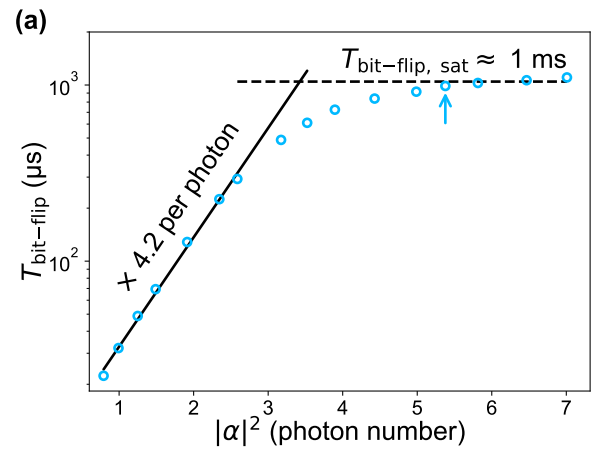

## $T_{pf}$ as a function of $\bar n = |\alpha|^2$

In [ ]:
def build_phase_flip_circuit(delay_duration_us: float) -> QuantumCircuit:
    circ = QuantumCircuit(1, 1)
    circ.initialize('+')
    circ.delay(delay_duration_us, 0, unit='us')
    circ.measure_x(0, 0)
    return circ

In [ ]:
circ = build_phase_flip_circuit(10)
circ.draw('mpl')

In [ ]:
nbars = range(1, 8)
delay_durations_us = np.logspace(-2, 2, 10)
shots = 10000

In [ ]:
tpf_fitted = []

for nbar in tqdm(nbars):
    jobs = []
    backend = provider.get_backend('EMU:1Q:LESCANNE_2020', average_nb_photons=nbar)
    for delay_duration_us in delay_durations_us:
        circ = build_phase_flip_circuit(delay_duration_us)
        jobs.append(backend.run(circ, shots=shots))
    results = [job.result() for job in jobs]
    flip_fractions = [r.get_counts().get('1', 0) / shots for r in results]
    Tpf, a, b = fit_typical_time(delay_durations_us, flip_fractions)
    tpf_fitted.append(Tpf)

In [ ]:
plt.figure()
plt.title('$\Gamma_{pf}=f(\\bar{n})$')
plt.plot([1, 7], [0.17, 1.01], c='k', lw=2, label='Linear increase of phase-flip rate')
plt.scatter(nbars, 0.5 / np.array(tpf_fitted), facecolors='none', edgecolors='tab:blue', s=100, lw=3, label='Simulation results')
plt.xlabel('$\\bar{n} = |\\alpha|^2$ (number of photons)')
plt.ylabel('$\Gamma_{pf}/2\pi$ [MHz]')
plt.legend(loc='lower right')
plt.show()

Corresponding plot in the paper: 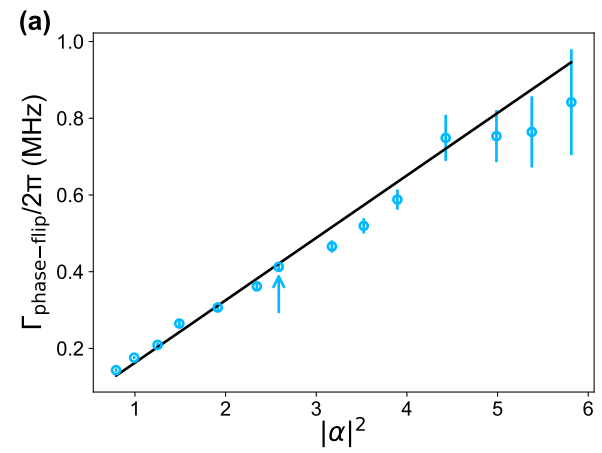